In [1]:
import os
import torch

# GPU 2를 사용하도록 환경 변수 설정
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 현재 사용 중인 GPU ID 확인
current_device = torch.cuda.current_device()
print(f"Current CUDA device: {current_device}")

# 현재 사용 중인 GPU 이름 확인
current_device_name = torch.cuda.get_device_name(current_device)
print(f"Current CUDA device name: {current_device_name}")

# 실제로 설정된 환경 변수를 확인
print(f"CUDA_VISIBLE_DEVICES: {os.environ.get('CUDA_VISIBLE_DEVICES')}")

Using device: cuda
Current CUDA device: 0
Current CUDA device name: NVIDIA RTX A5000
CUDA_VISIBLE_DEVICES: 0


In [2]:
import cv2
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.8 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [3]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

In [9]:
def image_to_patches(image, patch_size=512): # 이미지를 패치로 나누는 함수
    patches = []
    for i in range(0, image.shape[0], patch_size):
        for j in range(0, image.shape[1], patch_size):
            patch = image[i:i+patch_size, j:j+patch_size]
            if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                continue  # Skip patches that are smaller than patch_size
            patches.append(patch)
    return patches

class SatelliteDataset(Dataset):
    def __init__(self, image_dir, mask_dir, patch_size=512, transform=None, infer=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.infer = infer
        self.patch_size = patch_size
        self.image_files = sorted(os.listdir(image_dir)) # 이미지 파일 목록 정렬
        self.mask_files = sorted(os.listdir(mask_dir)) # 마스크 파일 목록 정렬

    def __len__(self):
        num_patches_per_image = (1920 // self.patch_size) ** 2
        return len(self.image_files) * num_patches_per_image  # 전체 데이터를 사용

    def __getitem__(self, idx):
        num_patches_per_image = (1920 // self.patch_size) ** 2 # 이미지당 패치 수
        img_idx = idx // num_patches_per_image # 이미지 인덱스
        patch_idx = idx % num_patches_per_image

        img_path = os.path.join(self.image_dir, self.image_files[img_idx]) # 이미지 경로
        mask_path = os.path.join(self.mask_dir, self.mask_files[img_idx])

        image = cv2.imread(img_path) # 이미지 읽기
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 채널 변경

        if self.infer: # 추론 시, 사실상 test dataset이 없으므로 없는 코드 
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # 이미지와 마스크를 패치로 나누기
        image_patches = image_to_patches(image, self.patch_size)
        mask_patches = image_to_patches(mask, self.patch_size)

        image = image_patches[patch_idx] # 이미지 패치
        mask = mask_patches[patch_idx]

        if self.transform: # 각 epoch마다 getitem을 통해 이미지와 마스크를 변환
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

# 데이터 증강 파이프라인 설정 (훈련용)
train_transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5), # 50% 확률로 좌우 반전
        A.VerticalFlip(p=0.5), # 50% 확률로 상하 반전
        A.RandomRotate90(p=0.5), # 50% 확률로 90도 회전
        # A.RandomBrightnessContrast(p=0.2),
        # A.OneOf([
        #     A.GaussianBlur(p=0.1),
        #     A.MotionBlur(p=0.1),
        # ], p=0.2),
        # A.ElasticTransform(p=0.1),
        A.Normalize(),
        ToTensorV2()
    ]
)

# 데이터 증강 파이프라인 설정 (검증용)
val_transform = A.Compose(
    [
        A.Normalize(),
        ToTensorV2()
    ]
)
# 데이터셋 인스턴스 생성
image_dir = './buildings/train_images'
mask_dir = './buildings/train_masks'

full_dataset = SatelliteDataset(image_dir=image_dir, mask_dir=mask_dir, patch_size=384, transform=None)

# 데이터셋을 train과 validation으로 분할
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size


# 랜덤 시드 설정
set_seed(42)
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# 각각의 데이터셋에 대해 다른 변환 적용
train_dataset = Subset(SatelliteDataset(image_dir=image_dir, mask_dir=mask_dir, 
                                        patch_size=384, transform=train_transform), train_dataset.indices)

val_dataset = Subset(SatelliteDataset(image_dir=image_dir, mask_dir=mask_dir, 
                                      patch_size=384, transform=val_transform), val_dataset.indices)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False, num_workers=4)

# 데이터셋 길이 확인
print(len(full_dataset))

# 데이터셋 길이 확인
print(f"Train dataset length: {len(train_dataset)}")
print(f"Validation dataset length: {len(val_dataset)}")

1000
Train dataset length: 800
Validation dataset length: 200


torch.Size([3, 384, 384]) torch.Size([384, 384])


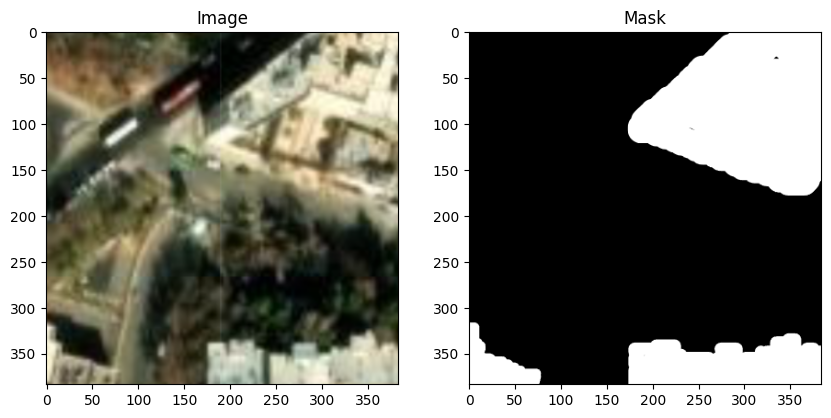

In [7]:

# 데이터 포인트 확인
image, mask = val_dataset[1]
print(image.shape, mask.shape)

def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# 이미지와 마스크를 시각화하는 함수
def visualize_sample(image, mask, mean, std):
    image = denormalize(image, mean, std)
    image = image.permute(1, 2, 0).cpu().numpy()  # 채널을 마지막으로 배치하고 numpy 배열로 변환
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)  # 역정규화된 이미지를 시각화
    ax[0].set_title('Image')
    ax[1].imshow(mask.cpu().numpy(), cmap='gray')
    ax[1].set_title('Mask')
    plt.show()

# 시각화
visualize_sample(image, mask, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [10]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)  # Sigmoid activation to get probability
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class BCEDiceLoss(nn.Module):
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        dice_loss = self.dice(inputs, targets)
        return bce_loss + dice_loss
    
def dice_score(inputs, targets, smooth=1):
    inputs = torch.sigmoid(inputs)  # Sigmoid activation to get probability
    inputs = (inputs > 0.5).float()  # Binarize the outputs at 0.5 threshold
    inputs = inputs.view(-1)
    targets = targets.view(-1)

    intersection = (inputs * targets).sum()
    dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
    return dice.item()

In [12]:
import segmentation_models_pytorch as smp
# hyper parameters 
epoch_num = 50
learning_rate = 0.001
patience = 4 # patience 횟수 동안 validation loss가 개선되지 않으면 학습을 조기 중지
early_stopping_counter = 5 # counter동안 validation loss가 개선되지 않으면 학습을 조기 중지
best_val_loss = float('inf')

# model 초기화 
model = smp.DeepLabV3(
    encoder_name="resnet50",          # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)
model = model.to(device)

# loss function과 optimizer 정의
criterion = BCEDiceLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                       factor=0.1, patience=patience)

# 손실 기록을 위한 리스트
train_losses = []
val_losses = []

best_epoch = 0
# training loop
for epoch in range(epoch_num):  # 30 에폭 동안 학습합니다.
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(train_loader):
        images = images.float().to(device) # 이미지와 마스크를 GPU로 이동
        masks = masks.float().to(device)
        masks = masks / 255  # 마스크를 0과 1로 변환

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        
    train_losses.append(epoch_loss / len(train_loader)) # training loss 기록
    print(f'Train Epoch {epoch+1}, Loss: {train_losses[-1]}')

    model.eval()
    with torch.no_grad():
        epoch_val_loss = 0
        epoch_val_dice = 0
        for images, masks in tqdm(val_loader):
            images = images.float().to(device) # 이미지와 마스크를 GPU로 이동
            masks = masks.float().to(device)
            masks = masks / 255  # 마스크를 0과 1로 변환

            outputs = model(images)
            val_loss = criterion(outputs, masks.unsqueeze(1))
            epoch_val_loss += val_loss.item()
            epoch_val_dice += dice_score(outputs, masks.unsqueeze(1))

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss) # validation loss 기록
        avg_val_dice = epoch_val_dice / len(val_loader)
        print(f'Val Epoch {epoch+1}, Loss: {avg_val_loss}, Dice Score: {avg_val_dice}')


        scheduler.step(avg_val_loss) # patience 동안 avg_val_loss가 개선되지 않으면 lr을 감소시킵니다.
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Learning Rate for Epoch {epoch+1}: {current_lr}')

        # Save the best model and apply early stopping
        if avg_val_loss < best_val_loss: 
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model2.pt') # validation loss가 감소하면 모델을 저장
            best_epoch = epoch + 1
            print("best epoch: ", best_epoch)
            # early_stopping_counter = 0  # Reset counter
        # else:
        #     early_stopping_counter += 1  # Increment counter
        #     if early_stopping_counter >= patience:
        #         print("Early stopping, best epoch: ", best_epoch)
        #         break
print("Training finished!, best epoch: ", best_epoch)

  0%|          | 0/40 [00:00<?, ?it/s]/home/a2024712006/miniconda3/envs/hwany_env/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/a2024712006/miniconda3/envs/hwany_env/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 1, Loss: 0.9295243248343468


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Val Epoch 1, Loss: 0.8328570485115051, Dice Score: 0.6646453648805618
Learning Rate for Epoch 1: 0.001
best epoch:  1


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 2, Loss: 0.6637419573962688


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Val Epoch 2, Loss: 0.6319351822137833, Dice Score: 0.7307786047458649
Learning Rate for Epoch 2: 0.001
best epoch:  2


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 3, Loss: 0.594836650788784


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Val Epoch 3, Loss: 0.6712522685527802, Dice Score: 0.7231492042541504
Learning Rate for Epoch 3: 0.001


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 4, Loss: 0.5361764580011368


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Val Epoch 4, Loss: 0.5595937937498092, Dice Score: 0.7540111005306244
Learning Rate for Epoch 4: 0.001
best epoch:  4


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 5, Loss: 0.5023814499378204


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Val Epoch 5, Loss: 0.4877962380647659, Dice Score: 0.7916929602622986
Learning Rate for Epoch 5: 0.001
best epoch:  5


100%|██████████| 40/40 [00:24<00:00,  1.62it/s]


Train Epoch 6, Loss: 0.48845321759581567


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Val Epoch 6, Loss: 0.44501428604125975, Dice Score: 0.8035896003246308
Learning Rate for Epoch 6: 0.001
best epoch:  6


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 7, Loss: 0.4491859547793865


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Val Epoch 7, Loss: 0.44608807265758516, Dice Score: 0.8114417850971222
Learning Rate for Epoch 7: 0.001


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 8, Loss: 0.4587340824306011


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Val Epoch 8, Loss: 0.406804746389389, Dice Score: 0.8266465365886688
Learning Rate for Epoch 8: 0.001
best epoch:  8


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 9, Loss: 0.4046316109597683


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Val Epoch 9, Loss: 0.41586277484893797, Dice Score: 0.8238888502120971
Learning Rate for Epoch 9: 0.001


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 10, Loss: 0.4623573936522007


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Val Epoch 10, Loss: 0.40613639652729033, Dice Score: 0.822999894618988
Learning Rate for Epoch 10: 0.001
best epoch:  10


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 11, Loss: 0.4058095164597034


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Val Epoch 11, Loss: 0.380745667219162, Dice Score: 0.8333795189857482
Learning Rate for Epoch 11: 0.001
best epoch:  11


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 12, Loss: 0.3814588263630867


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Val Epoch 12, Loss: 0.3477682501077652, Dice Score: 0.8476857960224151
Learning Rate for Epoch 12: 0.001
best epoch:  12


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 13, Loss: 0.3819434754550457


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Val Epoch 13, Loss: 0.37474925220012667, Dice Score: 0.8413943111896515
Learning Rate for Epoch 13: 0.001


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 14, Loss: 0.39833985939621924


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Val Epoch 14, Loss: 0.3744084030389786, Dice Score: 0.8360959589481354
Learning Rate for Epoch 14: 0.001


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 15, Loss: 0.3594437424093485


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Val Epoch 15, Loss: 0.3400885507464409, Dice Score: 0.8538240611553192
Learning Rate for Epoch 15: 0.001
best epoch:  15


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 16, Loss: 0.3646628618240356


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Val Epoch 16, Loss: 0.35121644139289854, Dice Score: 0.8492872238159179
Learning Rate for Epoch 16: 0.001


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 17, Loss: 0.3433607552200556


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Val Epoch 17, Loss: 0.32665032148361206, Dice Score: 0.8587730646133422
Learning Rate for Epoch 17: 0.001
best epoch:  17


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 18, Loss: 0.36213678047060965


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Val Epoch 18, Loss: 0.3567845046520233, Dice Score: 0.8491852283477783
Learning Rate for Epoch 18: 0.001


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 19, Loss: 0.3179600965231657


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Val Epoch 19, Loss: 0.31894353330135344, Dice Score: 0.8665467917919158
Learning Rate for Epoch 19: 0.001
best epoch:  19


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 20, Loss: 0.3035137288272381


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Val Epoch 20, Loss: 0.34939718097448347, Dice Score: 0.8528136134147644
Learning Rate for Epoch 20: 0.001


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 21, Loss: 0.32984905652701857


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Val Epoch 21, Loss: 0.385328534245491, Dice Score: 0.8366969347000122
Learning Rate for Epoch 21: 0.001


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 22, Loss: 0.3290827598422766


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Val Epoch 22, Loss: 0.319191537797451, Dice Score: 0.8610777497291565
Learning Rate for Epoch 22: 0.001


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 23, Loss: 0.3051725819706917


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Val Epoch 23, Loss: 0.31356282979249955, Dice Score: 0.869192773103714
Learning Rate for Epoch 23: 0.001
best epoch:  23


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 24, Loss: 0.339721591770649


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Val Epoch 24, Loss: 0.5460588008165359, Dice Score: 0.7782557785511017
Learning Rate for Epoch 24: 0.001


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 25, Loss: 0.31584759913384913


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Val Epoch 25, Loss: 0.30651384592056274, Dice Score: 0.8716518402099609
Learning Rate for Epoch 25: 0.001
best epoch:  25


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 26, Loss: 0.2777326084673405


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Val Epoch 26, Loss: 0.3172025829553604, Dice Score: 0.8649270057678222
Learning Rate for Epoch 26: 0.001


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 27, Loss: 0.2914984405040741


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Val Epoch 27, Loss: 0.3581770032644272, Dice Score: 0.8473225235939026
Learning Rate for Epoch 27: 0.001


100%|██████████| 40/40 [00:24<00:00,  1.64it/s]


Train Epoch 28, Loss: 0.2833671920001507


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Val Epoch 28, Loss: 0.32256127893924713, Dice Score: 0.8630439341068268
Learning Rate for Epoch 28: 0.001


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 29, Loss: 0.29068756885826585


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Val Epoch 29, Loss: 0.3743143707513809, Dice Score: 0.8486468195915222
Learning Rate for Epoch 29: 0.001


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 30, Loss: 0.32463401556015015


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Val Epoch 30, Loss: 0.30661007612943647, Dice Score: 0.8731015801429749
Learning Rate for Epoch 30: 0.0001


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 31, Loss: 0.2628109209239483


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Val Epoch 31, Loss: 0.28457341641187667, Dice Score: 0.8793236970901489
Learning Rate for Epoch 31: 0.0001
best epoch:  31


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 32, Loss: 0.23964499905705453


100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Val Epoch 32, Loss: 0.2741198629140854, Dice Score: 0.8836879014968873
Learning Rate for Epoch 32: 0.0001
best epoch:  32


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 33, Loss: 0.2296920668333769


100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Val Epoch 33, Loss: 0.27170365303754807, Dice Score: 0.88637934923172
Learning Rate for Epoch 33: 0.0001
best epoch:  33


100%|██████████| 40/40 [00:24<00:00,  1.64it/s]


Train Epoch 34, Loss: 0.22396775484085082


100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


Val Epoch 34, Loss: 0.26954970955848695, Dice Score: 0.8861966848373413
Learning Rate for Epoch 34: 0.0001
best epoch:  34


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 35, Loss: 0.22741696406155826


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Val Epoch 35, Loss: 0.26803200542926786, Dice Score: 0.8867847442626953
Learning Rate for Epoch 35: 0.0001
best epoch:  35


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 36, Loss: 0.21819433569908142


100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


Val Epoch 36, Loss: 0.2655543178319931, Dice Score: 0.8879936814308167
Learning Rate for Epoch 36: 0.0001
best epoch:  36


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 37, Loss: 0.21242192909121513


100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


Val Epoch 37, Loss: 0.2607265755534172, Dice Score: 0.8904668629169464
Learning Rate for Epoch 37: 0.0001
best epoch:  37


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 38, Loss: 0.21295088045299054


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Val Epoch 38, Loss: 0.26332315504550935, Dice Score: 0.8890849769115448
Learning Rate for Epoch 38: 0.0001


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 39, Loss: 0.21057049930095673


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Val Epoch 39, Loss: 0.25999005883932114, Dice Score: 0.8911028742790222
Learning Rate for Epoch 39: 0.0001
best epoch:  39


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 40, Loss: 0.21292328387498854


100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Val Epoch 40, Loss: 0.2585253074765205, Dice Score: 0.8919827461242675
Learning Rate for Epoch 40: 0.0001
best epoch:  40


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 41, Loss: 0.20665048398077487


100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


Val Epoch 41, Loss: 0.2598449349403381, Dice Score: 0.89082550406456
Learning Rate for Epoch 41: 0.0001


100%|██████████| 40/40 [00:24<00:00,  1.62it/s]


Train Epoch 42, Loss: 0.2041636347770691


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Val Epoch 42, Loss: 0.25794263035058973, Dice Score: 0.8920112311840057
Learning Rate for Epoch 42: 0.0001
best epoch:  42


100%|██████████| 40/40 [00:24<00:00,  1.62it/s]


Train Epoch 43, Loss: 0.20156748816370965


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Val Epoch 43, Loss: 0.2597019329667091, Dice Score: 0.8910765886306763
Learning Rate for Epoch 43: 0.0001


100%|██████████| 40/40 [00:24<00:00,  1.62it/s]


Train Epoch 44, Loss: 0.19839694388210774


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Val Epoch 44, Loss: 0.25415523648262023, Dice Score: 0.8938307225704193
Learning Rate for Epoch 44: 0.0001
best epoch:  44


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 45, Loss: 0.20005993358790874


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Val Epoch 45, Loss: 0.25324185490608214, Dice Score: 0.8934658288955688
Learning Rate for Epoch 45: 0.0001
best epoch:  45


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Train Epoch 46, Loss: 0.19608798548579215


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Val Epoch 46, Loss: 0.2557910233736038, Dice Score: 0.8935751259326935
Learning Rate for Epoch 46: 0.0001


100%|██████████| 40/40 [00:24<00:00,  1.62it/s]


Train Epoch 47, Loss: 0.19823959954082965


100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


Val Epoch 47, Loss: 0.25592050999403, Dice Score: 0.8933632254600525
Learning Rate for Epoch 47: 0.0001


100%|██████████| 40/40 [00:24<00:00,  1.62it/s]


Train Epoch 48, Loss: 0.1974138118326664


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Val Epoch 48, Loss: 0.2580221578478813, Dice Score: 0.8933377742767334
Learning Rate for Epoch 48: 0.0001


100%|██████████| 40/40 [00:24<00:00,  1.62it/s]


Train Epoch 49, Loss: 0.19226578250527382


100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Val Epoch 49, Loss: 0.25425655841827394, Dice Score: 0.8948319494724274
Learning Rate for Epoch 49: 0.0001


100%|██████████| 40/40 [00:24<00:00,  1.62it/s]


Train Epoch 50, Loss: 0.19553660452365876


100%|██████████| 10/10 [00:04<00:00,  2.05it/s]

Val Epoch 50, Loss: 0.2570915907621384, Dice Score: 0.8930712044239044
Learning Rate for Epoch 50: 1e-05
Training finished!, best epoch:  45


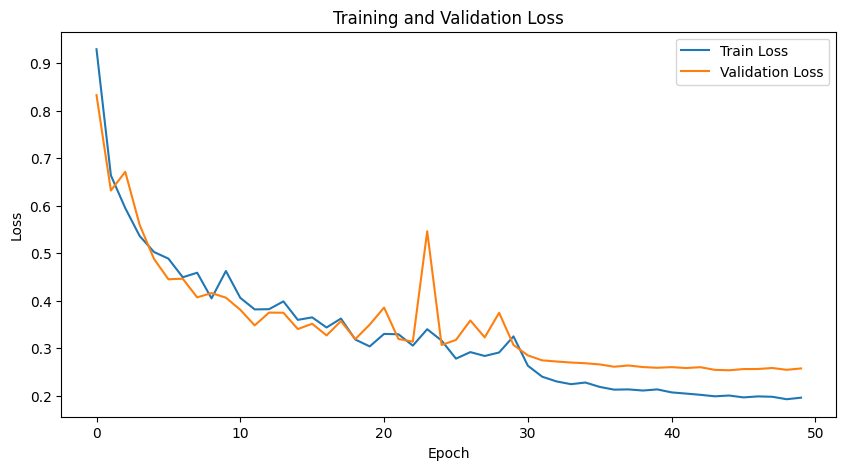

In [13]:
# 학습 손실 및 검증 손실 시각화
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# 손실 시각화
plot_losses(train_losses, val_losses)

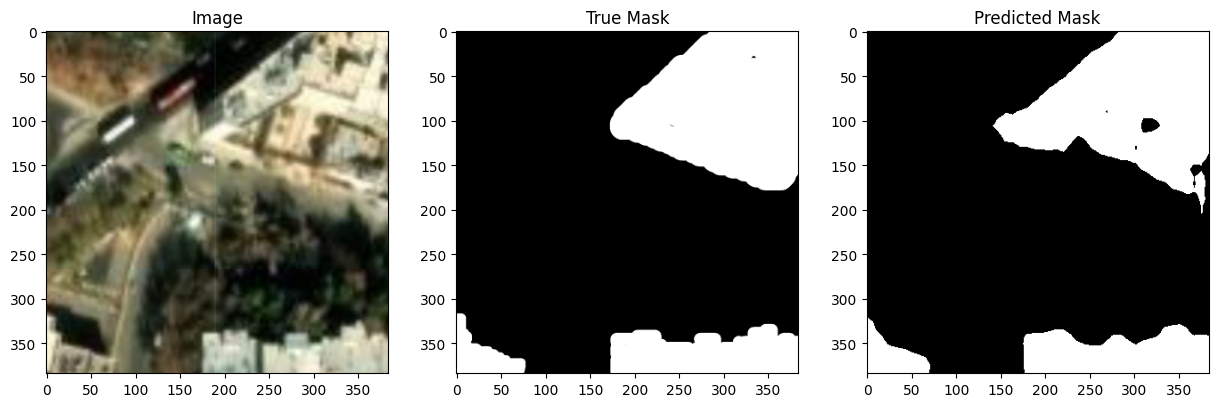

In [14]:
# 이미지와 마스크를 시각화하는 함수 (역정규화 포함)
# 이미지와 마스크를 시각화하는 함수 (역정규화 포함)
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def visualize_comparison(image, true_mask, pred_mask, mean, std):
    # Denormalize the image for visualization
    image = denormalize(image, mean, std)
    image = image.permute(1, 2, 0).cpu().numpy()  # 채널을 마지막으로 배치하고 numpy 배열로 변환
    true_mask = true_mask.cpu().numpy()
    pred_mask = pred_mask.squeeze().cpu().numpy()  # 채널 차원을 제거하여 (224, 224) 형태로 변환

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image)  # 역정규화된 이미지를 시각화
    ax[0].set_title('Image')
    ax[1].imshow(true_mask, cmap='gray')
    ax[1].set_title('True Mask')
    ax[2].imshow(pred_mask, cmap='gray')
    ax[2].set_title('Predicted Mask')
    plt.show()
    
# 특정 인덱스에서 이미지와 마스크 가져오기
def get_image_and_mask_at_index(dataset, index):
    image, mask = dataset[index]
    return image, mask

# 모델을 평가 모드로 전환
model.load_state_dict(torch.load('best_model2.pt'))
model.eval()

# 검증 데이터셋의 특정 인덱스
index = 1  # 원하는 인덱스로 변경
image, mask = get_image_and_mask_at_index(val_dataset, index)


# 모델로 마스크 추론
with torch.no_grad():
    image = image.float().to(device).unsqueeze(0)  # 배치 차원을 추가
    mask = mask.float().to(device).unsqueeze(0)
    mask = mask / 255  # 마스크를 0과 1로 변환

    output = model(image)
    pred = torch.sigmoid(output)  # Sigmoid activation to get probability
    pred = (pred > 0.5).float()  # Binarize the outputs at 0.5 threshold

# 첫 번째 이미지와 마스크를 시각화
visualize_comparison(image.squeeze(0), mask.squeeze(0), pred.squeeze(0), mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))